<a href="https://colab.research.google.com/github/sinarazi/Instance_segmentation_froth_flotation/blob/main/SSD300_RESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing prerequisite libraries

In [ ]:
!pip install keras==1.2.2

In [ ]:
!pip install scipy==1.1.0
!pip install -U scikit-image==0.16.2

In [ ]:
#%tensorflow_version 1.x
!pip install tensorflow==1.13.1

In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
import tensorflow as tf
import keras
import h5py

print(tf.__version__)
print(keras.__version__)
print(h5py.__version__)

In [ ]:
!wget https://github.com/sinarazi/Instance_segmentation_froth_flotation/blob/main/prior_boxes_ssd300.pkl
!wget https://github.com/sinarazi/Instance_segmentation_froth_flotation/blob/main/Froth.p

In [4]:
import cv2
import keras
import keras.backend as K
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.engine.topology import InputSpec, Layer
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Activation
from keras.layers import AtrousConvolution2D
from keras.layers import Convolution2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import merge
from keras.layers import Reshape
from keras.layers import ZeroPadding2D
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
# from scipy.misc import imread
# from scipy.misc import imresize
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

# Initial configuration:
###### Such as sizes of pixcels, the input/ output width and height.

In [6]:
class Normalize(Layer):

    def __init__(self, scale, **kwargs):
        if K.image_dim_ordering() == 'tf':
            self.axis = 3
        else:
            self.axis = 1
        self.scale = scale
        super(Normalize, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (input_shape[self.axis],)
        init_gamma = self.scale * np.ones(shape)
        self.gamma = K.variable(init_gamma, name='{}_gamma'.format(self.name))
        self.trainable_weights = [self.gamma]

    def call(self, x, mask=None):
        output = K.l2_normalize(x, self.axis)
        output *= self.gamma
        return output


class PriorBox(Layer):
    """Generate the prior boxes of designated sizes and aspect ratios.
    """
    def __init__(self, img_size, min_size, max_size=None, aspect_ratios=None,
                 flip=True, variances=[0.1], clip=True, **kwargs):
        if K.image_dim_ordering() == 'tf':
            self.waxis = 2
            self.haxis = 1
        else:
            self.waxis = 3
            self.haxis = 2
        self.img_size = img_size
        if min_size <= 0:
            raise Exception('min_size must be positive.')
        self.min_size = min_size
        self.max_size = max_size
        self.aspect_ratios = [1.0]
        if max_size:
            if max_size < min_size:
                raise Exception('max_size must be greater than min_size.')
            self.aspect_ratios.append(1.0)
        if aspect_ratios:
            for ar in aspect_ratios:
                if ar in self.aspect_ratios:
                    continue
                self.aspect_ratios.append(ar)
                if flip:
                    self.aspect_ratios.append(1.0 / ar)
        self.variances = np.array(variances)
        self.clip = True
        super(PriorBox, self).__init__(**kwargs)

    def get_output_shape_for(self, input_shape):
        num_priors_ = len(self.aspect_ratios)
        layer_width = input_shape[self.waxis]
        layer_height = input_shape[self.haxis]
        num_boxes = num_priors_ * layer_width * layer_height
        return (input_shape[0], num_boxes, 8)

    def call(self, x, mask=None):
        if hasattr(x, '_keras_shape'):
            input_shape = x._keras_shape
        elif hasattr(K, 'int_shape'):
            input_shape = K.int_shape(x)
        layer_width = input_shape[self.waxis]
        layer_height = input_shape[self.haxis]
        img_width = self.img_size[0]
        img_height = self.img_size[1]
        # define prior boxes shapes
        box_widths = []
        box_heights = []
        for ar in self.aspect_ratios:
            if ar == 1 and len(box_widths) == 0:
                box_widths.append(self.min_size)
                box_heights.append(self.min_size)
            elif ar == 1 and len(box_widths) > 0:
                box_widths.append(np.sqrt(self.min_size * self.max_size))
                box_heights.append(np.sqrt(self.min_size * self.max_size))
            elif ar != 1:
                box_widths.append(self.min_size * np.sqrt(ar))
                box_heights.append(self.min_size / np.sqrt(ar))
        box_widths = 0.5 * np.array(box_widths)
        box_heights = 0.5 * np.array(box_heights)
        # define centers of prior boxes
        step_x = img_width / layer_width
        step_y = img_height / layer_height
        linx = np.linspace(0.5 * step_x, img_width - 0.5 * step_x,
                           layer_width)
        liny = np.linspace(0.5 * step_y, img_height - 0.5 * step_y,
                           layer_height)
        centers_x, centers_y = np.meshgrid(linx, liny)
        centers_x = centers_x.reshape(-1, 1)
        centers_y = centers_y.reshape(-1, 1)
        # define xmin, ymin, xmax, ymax of prior boxes
        num_priors_ = len(self.aspect_ratios)
        prior_boxes = np.concatenate((centers_x, centers_y), axis=1)
        prior_boxes = np.tile(prior_boxes, (1, 2 * num_priors_))
        prior_boxes[:, ::4] -= box_widths
        prior_boxes[:, 1::4] -= box_heights
        prior_boxes[:, 2::4] += box_widths
        prior_boxes[:, 3::4] += box_heights
        prior_boxes[:, ::2] /= img_width
        prior_boxes[:, 1::2] /= img_height
        prior_boxes = prior_boxes.reshape(-1, 4)
        if self.clip:
            prior_boxes = np.minimum(np.maximum(prior_boxes, 0.0), 1.0)
        # define variances
        num_boxes = len(prior_boxes)
        if len(self.variances) == 1:
            variances = np.ones((num_boxes, 4)) * self.variances[0]
        elif len(self.variances) == 4:
            variances = np.tile(self.variances, (num_boxes, 1))
        else:
            raise Exception('Must provide one or four variances.')
        prior_boxes = np.concatenate((prior_boxes, variances), axis=1)
        prior_boxes_tensor = K.expand_dims(K.variable(prior_boxes), 0)
        if K.backend() == 'tensorflow':
            pattern = [tf.shape(x)[0], 1, 1]
            prior_boxes_tensor = tf.tile(prior_boxes_tensor, pattern)
        elif K.backend() == 'theano':
            #TODO
            pass
        return prior_boxes_tensor


# SSD300_RES-NET50 architecture
###### Deep residual network which consists of identity block and convolutional block. Fully connceted networks, which will be accepted pooling method so as to be specially filtered and reduced, and finally they will be flatten. Then, these flatten branch layers will help the prediction, and predicted answers will be concatenated (merged). 

In [7]:
#### Adapted from ResNet50, defining the shortcuts
def identity_block(input_tensor, kernel_size, filters, stage, block):

    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      border_mode='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum')
    x = Activation('relu')(x)
    return x


#### Adapted from ResNet50, defining a single ResNet50 convolutional block
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size, border_mode='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum')
    x = Activation('relu')(x)
    return x


def SSD300(input_shape, num_classes=21):
    net = {}
    # Block 1
    input_tensor = Input(shape=input_shape)
    img_size = (input_shape[1], input_shape[0])


    if K.image_dim_ordering() == 'th':
        input_shape = (3, 300, 300)
    else:
        input_shape = (300, 300, 3)

    if not K.is_keras_tensor(input_tensor):
        net['input'] = Input(tensor=input_tensor)
    else:
        net['input'] = input_tensor
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1

    # Block 1
    x = ZeroPadding2D((3, 3))(net['input'])
    net['conv1'] = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)
    net['bn_conv1'] = BatchNormalization(axis=bn_axis, name='bn_conv1')(net['conv1'])
    x = Activation('relu')(net['bn_conv1'])
    x = ZeroPadding2D((1,1))(x)
    net['pool1'] = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Block 2
    net['conv2_1'] = conv_block(net['pool1'], 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    net['conv2_2'] = identity_block(net['conv2_1'], 3, [64, 64, 256], stage=2, block='b')
    net['conv2_3'] = identity_block(net['conv2_2'], 3, [64, 64, 256], stage=2, block='c')

    # Block 3
    net['conv3_1'] = conv_block(net['conv2_3'], 3, [128, 128, 512], stage=3, block='a')
    net['conv3_2'] = identity_block(net['conv3_1'] , 3, [128, 128, 512], stage=3, block='b')
    net['conv3_3'] = identity_block(net['conv3_2'], 3, [128, 128, 512], stage=3, block='c')
    net['conv3_4'] = identity_block(net['conv3_3'], 3, [128, 128, 512], stage=3, block='d')

    # Block 4
    net['conv4_1'] = conv_block(net['conv3_4'], 3, [256, 256, 1024], stage=4, block='a')
    net['conv4_2'] = identity_block(net['conv4_1'], 3, [256, 256, 1024], stage=4, block='b')
    net['conv4_3'] = identity_block(net['conv4_2'], 3, [256, 256, 1024], stage=4, block='c')
    net['conv4_4'] = identity_block(net['conv4_3'], 3, [256, 256, 1024], stage=4, block='d')
    net['conv4_5'] = identity_block(net['conv4_4'], 3, [256, 256, 1024], stage=4, block='e')
    net['conv4_6'] = identity_block(net['conv4_5'], 3, [256, 256, 1024], stage=4, block='f')

    # Block 5
    net['conv5_1']  = conv_block(net['conv4_6'], 3, [512, 512, 2048], stage=5, block='a')
    net['conv5_2'] = identity_block(net['conv5_1'], 3, [512, 512, 2048], stage=5, block='b')
    net['conv5_3'] = identity_block(net['conv5_2'], 3, [512, 512, 2048], stage=5, block='c')

    net['pool5v'] = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same',
                            name='pool5v')(net['conv5_3'])


## END ResNet50
#####################################################################################

    # FC6
    net['fc6'] = AtrousConvolution2D(1024, 3, 3, atrous_rate=(6, 6),
                                     activation='relu', border_mode='same',
                                     name='fc6')(net['pool5v'])
    # x = Dropout(0.5, name='drop6')(x)
    # FC7
    net['fc7'] = Convolution2D(1024, 1, 1, activation='relu',
                               border_mode='same', name='fc7')(net['fc6'])
    # x = Dropout(0.5, name='drop7')(x)
    # Block 6
    net['conv6_1'] = Convolution2D(256, 1, 1, activation='relu',
                                   border_mode='same',
                                   name='conv6_1')(net['fc7'])

    net['conv6_2'] = ZeroPadding2D()(net['conv6_1'])
    net['conv6_2'] = Convolution2D(512, 3, 3, subsample=(2, 2),
                                   activation='relu', border_mode='valid',
                                   name='conv6_2')(net['conv6_2'])
    # Block 7
    net['conv7_1'] = Convolution2D(128, 1, 1, activation='relu',
                                   border_mode='same',
                                   name='conv7_1')(net['conv6_2'])
    net['conv7_2'] = ZeroPadding2D()(net['conv7_1'])
    net['conv7_2'] = Convolution2D(256, 3, 3, subsample=(2, 2),
                                   activation='relu', border_mode='valid',
                                   name='conv7_2')(net['conv7_2'])
    # Block 8
    net['conv8_1'] = Convolution2D(128, 1, 1, activation='relu',
                                   border_mode='same',
                                   name='conv8_1')(net['conv7_2'])
    net['conv8_2'] = ZeroPadding2D()(net['conv8_1'])
    net['conv8_2'] = Convolution2D(256, 3, 3, subsample=(2, 2),
                                   activation='relu', border_mode='valid',
                                   name='conv8_2')(net['conv8_2'])
    # Last Pool
    net['pool6'] = GlobalAveragePooling2D(name='pool6')(net['conv8_2'])

    # Prediction from conv3_4 (still called conv4_3 in the remainder)
    # Will clean this up after training tests
    net['conv4_3_norm'] = Normalize(20, name='conv4_3_norm')(net['conv3_4'])
    num_priors = 3
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv4_3_norm_mbox_loc')(net['conv4_3_norm'])
    net['conv4_3_norm_mbox_loc'] = x
    flatten = Flatten(name='conv4_3_norm_mbox_loc_flat')
    net['conv4_3_norm_mbox_loc_flat'] = flatten(net['conv4_3_norm_mbox_loc'])
    name = 'conv4_3_norm_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv4_3_norm'])
    net['conv4_3_norm_mbox_conf'] = x
    flatten = Flatten(name='conv4_3_norm_mbox_conf_flat')
    net['conv4_3_norm_mbox_conf_flat'] = flatten(net['conv4_3_norm_mbox_conf'])
    priorbox = PriorBox(img_size, 30.0, aspect_ratios=[2],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv4_3_norm_mbox_priorbox')
    net['conv4_3_norm_mbox_priorbox'] = priorbox(net['conv4_3_norm'])

    # Prediction from conv4_6 -- again, will replace after train test
    num_priors = 6
    net['fc7_mbox_loc'] = Convolution2D(num_priors * 4, 3, 3,
                                        border_mode='same',
                                        name='fc7_mbox_loc')(net['conv4_6'])
    flatten = Flatten(name='fc7_mbox_loc_flat')
    net['fc7_mbox_loc_flat'] = flatten(net['fc7_mbox_loc'])
    name = 'fc7_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    net['fc7_mbox_conf'] = Convolution2D(num_priors * num_classes, 3, 3,
                                         border_mode='same',
                                         name=name)(net['conv4_6']) # changed from fc7
    flatten = Flatten(name='fc7_mbox_conf_flat')
    net['fc7_mbox_conf_flat'] = flatten(net['fc7_mbox_conf'])
    priorbox = PriorBox(img_size, 60.0, max_size=114.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='fc7_mbox_priorbox')

    # Another change from fc7
    net['fc7_mbox_priorbox'] = priorbox(net['conv4_6'])

    # Prediction from this fc7 (it will still be called 6_2)
    # project it so that its channels are 512, as bounding box data
    net['fc7_mbox_pre'] = Convolution2D(512, 1, 1, activation='relu',
                               border_mode='same', name='fc7_mbox_pre')(net['fc7'])
    num_priors = 6
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv6_2_mbox_loc')(net['fc7_mbox_pre'])
    net['conv6_2_mbox_loc'] = x
    flatten = Flatten(name='conv6_2_mbox_loc_flat')
    net['conv6_2_mbox_loc_flat'] = flatten(net['conv6_2_mbox_loc'])
    name = 'conv6_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['fc7_mbox_pre']) #changed from conv6_2
    net['conv6_2_mbox_conf'] = x
    flatten = Flatten(name='conv6_2_mbox_conf_flat')
    net['conv6_2_mbox_conf_flat'] = flatten(net['conv6_2_mbox_conf'])
    priorbox = PriorBox(img_size, 114.0, max_size=168.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv6_2_mbox_priorbox')
    net['conv6_2_mbox_priorbox'] = priorbox(net['fc7_mbox_pre']) # changed from conv6_2

    # Prediction from conv6_2
    # Project it down to 256
    # (old conv7_2)
    net['conv6_2_mbox_pre'] = Convolution2D(256, 1, 1, activation='relu',
                               border_mode='same', name='conv6_2_mbox_pre')(net['conv6_2'])
    num_priors = 6
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv7_2_mbox_loc')(net['conv6_2_mbox_pre'])
    net['conv7_2_mbox_loc'] = x
    flatten = Flatten(name='conv7_2_mbox_loc_flat')
    net['conv7_2_mbox_loc_flat'] = flatten(net['conv7_2_mbox_loc'])
    name = 'conv7_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv6_2_mbox_pre']) #changed from conv7_2
    net['conv7_2_mbox_conf'] = x
    flatten = Flatten(name='conv7_2_mbox_conf_flat')
    net['conv7_2_mbox_conf_flat'] = flatten(net['conv7_2_mbox_conf'])
    priorbox = PriorBox(img_size, 168.0, max_size=222.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv7_2_mbox_priorbox')
    # old conv7_2
    net['conv7_2_mbox_priorbox'] = priorbox(net['conv6_2_mbox_pre'])
    # Prediction from conv7_2
    # old (conv8_2)
    # no projections needed

    num_priors = 6
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv8_2_mbox_loc')(net['conv7_2'])
    net['conv8_2_mbox_loc'] = x
    flatten = Flatten(name='conv8_2_mbox_loc_flat')
    net['conv8_2_mbox_loc_flat'] = flatten(net['conv8_2_mbox_loc'])
    name = 'conv8_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv7_2']) # changed from conv8_2
    net['conv8_2_mbox_conf'] = x
    flatten = Flatten(name='conv8_2_mbox_conf_flat')
    net['conv8_2_mbox_conf_flat'] = flatten(net['conv8_2_mbox_conf'])
    priorbox = PriorBox(img_size, 222.0, max_size=276.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv8_2_mbox_priorbox')

    net['conv8_2_mbox_priorbox'] = priorbox(net['conv7_2']) #changed from conv8_2
    # Prediction from pool6
    num_priors = 6
    x = Dense(num_priors * 4, name='pool6_mbox_loc_flat')(net['pool6'])
    net['pool6_mbox_loc_flat'] = x
    name = 'pool6_mbox_conf_flat'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Dense(num_priors * num_classes, name=name)(net['pool6'])
    net['pool6_mbox_conf_flat'] = x
    priorbox = PriorBox(img_size, 276.0, max_size=330.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='pool6_mbox_priorbox')
    if K.image_dim_ordering() == 'tf':
        target_shape = (1, 1, 256)
    else:
        target_shape = (256, 1, 1)
    net['pool6_reshaped'] = Reshape(target_shape,
                                    name='pool6_reshaped')(net['pool6'])
    net['pool6_mbox_priorbox'] = priorbox(net['pool6_reshaped'])
    # Gather all predictions
    net['mbox_loc'] = merge([net['conv4_3_norm_mbox_loc_flat'],
                             net['fc7_mbox_loc_flat'],
                             net['conv6_2_mbox_loc_flat'],
                             net['conv7_2_mbox_loc_flat'],
                             net['conv8_2_mbox_loc_flat'],
                             net['pool6_mbox_loc_flat']],
                            mode='concat', concat_axis=1, name='mbox_loc')
    net['mbox_conf'] = merge([net['conv4_3_norm_mbox_conf_flat'],
                              net['fc7_mbox_conf_flat'],
                              net['conv6_2_mbox_conf_flat'],
                              net['conv7_2_mbox_conf_flat'],
                              net['conv8_2_mbox_conf_flat'],
                              net['pool6_mbox_conf_flat']],
                             mode='concat', concat_axis=1, name='mbox_conf')
    net['mbox_priorbox'] = merge([net['conv4_3_norm_mbox_priorbox'],
                                  net['fc7_mbox_priorbox'],
                                  net['conv6_2_mbox_priorbox'],
                                  net['conv7_2_mbox_priorbox'],
                                  net['conv8_2_mbox_priorbox'],
                                  net['pool6_mbox_priorbox']],
                                 mode='concat', concat_axis=1,
                                 name='mbox_priorbox')
    if hasattr(net['mbox_loc'], '_keras_shape'):
        num_boxes = net['mbox_loc']._keras_shape[-1] // 4
    elif hasattr(net['mbox_loc'], 'int_shape'):
        num_boxes = K.int_shape(net['mbox_loc'])[-1] // 4
    net['mbox_loc'] = Reshape((num_boxes, 4),
                              name='mbox_loc_final')(net['mbox_loc'])
    net['mbox_conf'] = Reshape((num_boxes, num_classes),
                               name='mbox_conf_logits')(net['mbox_conf'])
    net['mbox_conf'] = Activation('softmax',
                                  name='mbox_conf_final')(net['mbox_conf'])
    net['predictions'] = merge([net['mbox_loc'],
                               net['mbox_conf'],
                               net['mbox_priorbox']],
                               mode='concat', concat_axis=2,
                               name='predictions')
    model = Model(net['input'], net['predictions'])
    return model


# Various losses:
Losses along with specific nomalization methods should be calculated.

In [8]:
class MultiboxLoss(object):

    def __init__(self, num_classes, alpha=1.0, neg_pos_ratio=3.0,
                 background_label_id=0, negatives_for_hard=100.0):
        self.num_classes = num_classes
        self.alpha = alpha
        self.neg_pos_ratio = neg_pos_ratio
        if background_label_id != 0:
            raise Exception('Only 0 as background label id is supported')
        self.background_label_id = background_label_id
        self.negatives_for_hard = negatives_for_hard

    def _l1_smooth_loss(self, y_true, y_pred):

        abs_loss = tf.abs(y_true - y_pred)
        sq_loss = 0.5 * (y_true - y_pred)**2
        l1_loss = tf.where(tf.less(abs_loss, 1.0), sq_loss, abs_loss - 0.5)
        return tf.reduce_sum(l1_loss, -1)

    def _softmax_loss(self, y_true, y_pred):

        y_pred = tf.maximum(tf.minimum(y_pred, 1 - 1e-15), 1e-15)
        softmax_loss = -tf.reduce_sum(y_true * tf.log(y_pred),
                                      axis=-1)
        return softmax_loss

    def compute_loss(self, y_true, y_pred):
        """Compute mutlibox loss.
        """
        batch_size = tf.shape(y_true)[0]
        num_boxes = tf.to_float(tf.shape(y_true)[1])

        # loss for all priors
        conf_loss = self._softmax_loss(y_true[:, :, 4:-8],
                                       y_pred[:, :, 4:-8])
        loc_loss = self._l1_smooth_loss(y_true[:, :, :4],
                                        y_pred[:, :, :4])

        # get positives loss
        num_pos = tf.reduce_sum(y_true[:, :, -8], axis=-1)
        pos_loc_loss = tf.reduce_sum(loc_loss * y_true[:, :, -8],
                                     axis=1)
        pos_conf_loss = tf.reduce_sum(conf_loss * y_true[:, :, -8],
                                      axis=1)

        # get negatives loss, we penalize only confidence here
        num_neg = tf.minimum(self.neg_pos_ratio * num_pos,
                             num_boxes - num_pos)
        pos_num_neg_mask = tf.greater(num_neg, 0)
        has_min = tf.to_float(tf.reduce_any(pos_num_neg_mask))
        num_neg = tf.concat(axis=0, values=[num_neg,
                                [(1 - has_min) * self.negatives_for_hard]])
        num_neg_batch = tf.reduce_min(tf.boolean_mask(num_neg,
                                                      tf.greater(num_neg, 0)))
        num_neg_batch = tf.to_int32(num_neg_batch)
        confs_start = 4 + self.background_label_id + 1
        confs_end = confs_start + self.num_classes - 1
        max_confs = tf.reduce_max(y_pred[:, :, confs_start:confs_end],
                                  axis=2)
        _, indices = tf.nn.top_k(max_confs * (1 - y_true[:, :, -8]),
                                 k=num_neg_batch)
        batch_idx = tf.expand_dims(tf.range(0, batch_size), 1)
        batch_idx = tf.tile(batch_idx, (1, num_neg_batch))
        full_indices = (tf.reshape(batch_idx, [-1]) * tf.to_int32(num_boxes) +
                        tf.reshape(indices, [-1]))
        # full_indices = tf.concat(2, [tf.expand_dims(batch_idx, 2),
        #                              tf.expand_dims(indices, 2)])
        # neg_conf_loss = tf.gather_nd(conf_loss, full_indices)
        neg_conf_loss = tf.gather(tf.reshape(conf_loss, [-1]),
                                  full_indices)
        neg_conf_loss = tf.reshape(neg_conf_loss,
                                   [batch_size, num_neg_batch])
        neg_conf_loss = tf.reduce_sum(neg_conf_loss, axis=1)

        # loss is sum of positives and negatives
        total_loss = pos_conf_loss + neg_conf_loss
        total_loss /= (num_pos + tf.to_float(num_neg_batch))
        num_pos = tf.where(tf.not_equal(num_pos, 0), num_pos,
                            tf.ones_like(num_pos))
        total_loss += (self.alpha * pos_loc_loss) / num_pos
        return total_loss


# Bounding Box: 
We have to difine intersection over union, checking overlaps, considering the previous layers and prediction.

In [9]:
class BBoxUtility(object):
    def __init__(self, num_classes, priors=None, overlap_threshold=0.5,
                 nms_thresh=0.45, top_k=400):
        self.num_classes = num_classes
        self.priors = priors
        self.num_priors = 0 if priors is None else len(priors)
        self.overlap_threshold = overlap_threshold
        self._nms_thresh = nms_thresh
        self._top_k = top_k
        self.boxes = tf.placeholder(dtype='float32', shape=(None, 4))
        self.scores = tf.placeholder(dtype='float32', shape=(None,))
        self.nms = tf.image.non_max_suppression(self.boxes, self.scores,
                                                self._top_k,
                                                iou_threshold=self._nms_thresh)
        self.sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))

    @property
    def nms_thresh(self):
        return self._nms_thresh

    @nms_thresh.setter
    def nms_thresh(self, value):
        self._nms_thresh = value
        self.nms = tf.image.non_max_suppression(self.boxes, self.scores,
                                                self._top_k,
                                                iou_threshold=self._nms_thresh)

    @property
    def top_k(self):
        return self._top_k

    @top_k.setter
    def top_k(self, value):
        self._top_k = value
        self.nms = tf.image.non_max_suppression(self.boxes, self.scores,
                                                self._top_k,
                                                iou_threshold=self._nms_thresh)

    def iou(self, box):
        """Compute intersection over union for the box with all priors.
        """
        inter_upleft = np.maximum(self.priors[:, :2], box[:2])
        inter_botright = np.minimum(self.priors[:, 2:4], box[2:])
        inter_wh = inter_botright - inter_upleft
        inter_wh = np.maximum(inter_wh, 0)
        inter = inter_wh[:, 0] * inter_wh[:, 1]
        # compute union
        area_pred = (box[2] - box[0]) * (box[3] - box[1])
        area_gt = (self.priors[:, 2] - self.priors[:, 0])
        area_gt *= (self.priors[:, 3] - self.priors[:, 1])
        union = area_pred + area_gt - inter
        # compute iou
        iou = inter / union
        return iou

    def encode_box(self, box, return_iou=True):
        """Encode box for training, do it only for assigned priors.
        """
        iou = self.iou(box)
        encoded_box = np.zeros((self.num_priors, 4 + return_iou))
        assign_mask = iou > self.overlap_threshold
        if not assign_mask.any():
            assign_mask[iou.argmax()] = True
        if return_iou:
            encoded_box[:, -1][assign_mask] = iou[assign_mask]
        assigned_priors = self.priors[assign_mask]
        box_center = 0.5 * (box[:2] + box[2:])
        box_wh = box[2:] - box[:2]
        assigned_priors_center = 0.5 * (assigned_priors[:, :2] +
                                        assigned_priors[:, 2:4])
        assigned_priors_wh = (assigned_priors[:, 2:4] -
                              assigned_priors[:, :2])
        # we encode variance
        encoded_box[:, :2][assign_mask] = box_center - assigned_priors_center
        encoded_box[:, :2][assign_mask] /= assigned_priors_wh
        encoded_box[:, :2][assign_mask] /= assigned_priors[:, -4:-2]
        encoded_box[:, 2:4][assign_mask] = np.log(box_wh /
                                                  assigned_priors_wh)
        encoded_box[:, 2:4][assign_mask] /= assigned_priors[:, -2:]
        return encoded_box.ravel()

    def assign_boxes(self, boxes):
        """Assign boxes to priors for training.
        """
        assignment = np.zeros((self.num_priors, 4 + self.num_classes + 8))
        assignment[:, 4] = 1.0
        if len(boxes) == 0:
            return assignment
        encoded_boxes = np.apply_along_axis(self.encode_box, 1, boxes[:, :4])
        encoded_boxes = encoded_boxes.reshape(-1, self.num_priors, 5)
        best_iou = encoded_boxes[:, :, -1].max(axis=0)
        best_iou_idx = encoded_boxes[:, :, -1].argmax(axis=0)
        best_iou_mask = best_iou > 0
        best_iou_idx = best_iou_idx[best_iou_mask]
        assign_num = len(best_iou_idx)
        encoded_boxes = encoded_boxes[:, best_iou_mask, :]
        assignment[:, :4][best_iou_mask] = encoded_boxes[best_iou_idx,
                                                         np.arange(assign_num),
                                                         :4]
        assignment[:, 4][best_iou_mask] = 0
        assignment[:, 5:-8][best_iou_mask] = boxes[best_iou_idx, 4:]
        assignment[:, -8][best_iou_mask] = 1
        return assignment

    def decode_boxes(self, mbox_loc, mbox_priorbox, variances):
        """Convert bboxes from local predictions to shifted priors.
        """
        prior_width = mbox_priorbox[:, 2] - mbox_priorbox[:, 0]
        prior_height = mbox_priorbox[:, 3] - mbox_priorbox[:, 1]
        prior_center_x = 0.5 * (mbox_priorbox[:, 2] + mbox_priorbox[:, 0])
        prior_center_y = 0.5 * (mbox_priorbox[:, 3] + mbox_priorbox[:, 1])
        decode_bbox_center_x = mbox_loc[:, 0] * prior_width * variances[:, 0]
        decode_bbox_center_x += prior_center_x
        decode_bbox_center_y = mbox_loc[:, 1] * prior_width * variances[:, 1]
        decode_bbox_center_y += prior_center_y
        decode_bbox_width = np.exp(mbox_loc[:, 2] * variances[:, 2])
        decode_bbox_width *= prior_width
        decode_bbox_height = np.exp(mbox_loc[:, 3] * variances[:, 3])
        decode_bbox_height *= prior_height
        decode_bbox_xmin = decode_bbox_center_x - 0.5 * decode_bbox_width
        decode_bbox_ymin = decode_bbox_center_y - 0.5 * decode_bbox_height
        decode_bbox_xmax = decode_bbox_center_x + 0.5 * decode_bbox_width
        decode_bbox_ymax = decode_bbox_center_y + 0.5 * decode_bbox_height
        decode_bbox = np.concatenate((decode_bbox_xmin[:, None],
                                      decode_bbox_ymin[:, None],
                                      decode_bbox_xmax[:, None],
                                      decode_bbox_ymax[:, None]), axis=-1)
        decode_bbox = np.minimum(np.maximum(decode_bbox, 0.0), 1.0)
        return decode_bbox

    def detection_out(self, predictions, background_label_id=0, keep_top_k=200,
                      confidence_threshold=0.01):
        """Do non maximum suppression (nms) on prediction results.
        """
        mbox_loc = predictions[:, :, :4]
        variances = predictions[:, :, -4:]
        mbox_priorbox = predictions[:, :, -8:-4]
        mbox_conf = predictions[:, :, 4:-8]
        results = []
        for i in range(len(mbox_loc)):
            results.append([])
            decode_bbox = self.decode_boxes(mbox_loc[i],
                                            mbox_priorbox[i], variances[i])
            for c in range(self.num_classes):
                if c == background_label_id:
                    continue
                c_confs = mbox_conf[i, :, c]
                c_confs_m = c_confs > confidence_threshold
                if len(c_confs[c_confs_m]) > 0:
                    boxes_to_process = decode_bbox[c_confs_m]
                    confs_to_process = c_confs[c_confs_m]
                    feed_dict = {self.boxes: boxes_to_process,
                                 self.scores: confs_to_process}
                    idx = self.sess.run(self.nms, feed_dict=feed_dict)
                    good_boxes = boxes_to_process[idx]
                    confs = confs_to_process[idx][:, None]
                    labels = c * np.ones((len(idx), 1))
                    c_pred = np.concatenate((labels, confs, good_boxes),
                                            axis=1)
                    results[-1].extend(c_pred)
            if len(results[-1]) > 0:
                results[-1] = np.array(results[-1])
                argsort = np.argsort(results[-1][:, 1])[::-1]
                results[-1] = results[-1][argsort]
                results[-1] = results[-1][:keep_top_k]
        return results

In [13]:
# some constants
NUM_CLASSES = 2
input_shape = (300, 300, 3)

In [14]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#### Microsoft COCO dataset

In [ ]:
'''
import shutil
!wget http://host.robots.ox.ac.uk:8080/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar -c
!mkdir PASCAL_VOC
#!tar -xvf 'VOCtrainval_06-Nov-2007.tar' -C 'content/PASCAL_VOC'
shutil.unpack_archive("VOCtrainval_06-Nov-2007.tar")
'''

## Google drive dataset (Froth Floatation dataset)

In [16]:
PASCAL_VOC = '/content/drive/MyDrive/Dataset/'

In [18]:
gt = pickle.load(open('/content/Froth.p', 'rb'))
keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

# Configuration:
Generating grayscale, saturation, brightness, contrast, random_sized_crop and so on in order to be projected on test data.




In [19]:
class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:            
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = resize(img, self.image_size).astype('float32')
                if train: 
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets

In [20]:
path_prefix = PASCAL_VOC
gen = Generator(gt, bbox_util, 16, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

In [21]:
RESNET_MODEL_URL = "https://github.com/fchollet/deep-learning-models/releases/download/v0.1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
def download_trained_weights(resnet_model_path, verbose=1):
    if verbose > 0:
        print("Downloading pretrained model to " + resnet_model_path + " ...")
    with urllib.request.urlopen(RESNET_MODEL_URL) as resp, open(resnet_model_path, 'wb') as out:
        shutil.copyfileobj(resp, out)
    if verbose > 0:
        print("... done downloading pretrained model!")

In [22]:
import os
import urllib.request
import shutil
import h5py as h5

# Root directory of the project
ROOT_DIR = os.getcwd()

# Local path to trained weights file
RESNET_MODEL_PATH = os.path.join(ROOT_DIR, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(RESNET_MODEL_PATH):
    download_trained_weights(RESNET_MODEL_PATH)

model = SSD300(input_shape, num_classes=NUM_CLASSES)
# load weights trained by ImageNet
model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

... done downloading pretrained model!
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [23]:
layernames = [L.name for L in model.layers]
layernames.index('res4e_branch2a')

123

In [24]:
nofreeze = layernames[123:]
#nofreeze += ['res3d_branch2a','bn3d_branch2a', 'res3d_branch2b','bn3d_branch2b','res3d_branch2c','bn3d_branch2c',# conv3_4
#            'res4f_branch2a','bn4f_branch2a','res4f_branch2b','bn4f_branch2b','res4f_branch2c','bn4f_branch2c'] # conv4_6
nofreeze = set(nofreeze)
for L in model.layers:
    if L.name not in nofreeze:
        L.trainable = False

In [25]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 300, 300, 3)   0                                            
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 306, 306, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 150, 150, 64)  9472        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 150, 150, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [26]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('/content/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.h5',
                                             verbose=1,
                                             save_weights_only=True),
                 keras.callbacks.TensorBoard(log_dir=MODEL_DIR,
                                histogram_freq=0, write_graph=True, write_images=False),
             keras.callbacks.LearningRateScheduler(schedule)]

In [27]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [28]:
nb_epoch = 1
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_batches,
                              nb_worker=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1
64/79 [=======================>......] - ETA: 32s - loss: 8.7545

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: saving model to /content/checkpoints/weights.00-7.43.h5
80/79 [==============================] - 202s - loss: 8.5110 - val_loss: 7.4293


In [30]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard module is not an IPython extension.


UsageError: Line magic function `%tensorboard` not found.


In [ ]:
base_lr = 3e-4*0.9**16
model_path = '/content/checkpoints/weights.00-7.43.h5'

model.load_weights(model_path)
#model.load_weights('/content/checkpoints/weights.00-43.50.h5')
optim = keras.optimizers.Adam(lr=base_lr)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)
nb_epoch=2
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_batches,
                              nb_worker=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2


In [ ]:
%autosave 120

Autosaving every 120 seconds


In [ ]:
inputs = []
images = []
for i in range(20):
    img_path = path_prefix + sorted(val_keys)[i]
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  import sys


In [ ]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

20/20 [==============================] - 11s    


In [ ]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
voc_classes = ['nucleus']

IndexError: ignored

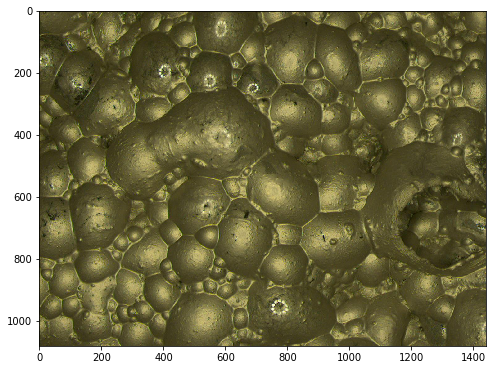

In [ ]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]


    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()